##***DeepFake Detection Using Deep Learning***




This notebook was used to train the Pure EfficientNet Model with hyperparameters found by manual search

## **Setup and Library Imports**

In [1]:
import os
import glob
import random
import torch
import cv2
from torch import nn
import seaborn as sn
import pandas as pd
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt 

import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
seed=40302
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## **Helper Functions**

In [3]:
import os
os.chdir('../')

In [4]:
from src.utils import *

## **Data Reading, Splitting and Loading**

In [5]:
from src.dataset import *

In [6]:
train_df, valid_df, test_df, test_celeb = load_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


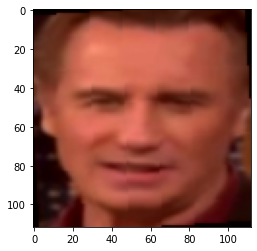

In [10]:
#preprocess the data
train_data = VideoDataset(train_df, frames_to_use = 30, im_size=112, transform = train_transforms(112))
val_data = VideoDataset(valid_df, frames_to_use = 30, im_size=112, transform = test_transforms(112))

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)

#plot the data
image,label = train_data[1500]
im_plot(image[2,:,:,:])

## **Model 1 : Efficientnet

In [11]:
from src.models.deepfake_detectors import Efficientnet

In [12]:
#instantiate the model
model1 = Efficientnet(2, dropout_rate=0.3).cuda()
#model1 = CNNModel().cuda()

In [13]:
print(model1)

Efficientnet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation)

In [14]:
#train function for CNN Model
def train_epoch(epoch, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for i, (inputs, targets) in pbar:
       
        
        targets = targets.type(torch.cuda.LongTensor)
        inputs = inputs.cuda()

        bs,frames_to_use, *_= inputs.shape
        outputs = model(inputs)   #call the model with inputs
        results = torch.zeros((bs,2)).cuda()
        
        #takes each sequence of frames that composes one video and calculate the mean output as the result
        for k, j in enumerate(range(0,bs*frames_to_use,frames_to_use)):
            results[k] = torch.mean(outputs[j:j+frames_to_use],dim=0)   
        
        #calculate loss and accuracy

        loss  = criterion(results,targets)  
        acc = calculate_accuracy(results, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #add comment to progress bar 
        description = f'epoch {epoch} loss: {losses.avg:.4f} {accuracies.avg:.2f}'   
        pbar.set_description(description)
    
    return losses.avg,accuracies.avg

#validate function
def run_inference(model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        
        pbar = tqdm(enumerate(data_loader), total=len(data_loader))
        
        for i, (inputs, targets) in pbar:

            targets = targets.cuda().type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
           
            bs,frames_to_use, *_ = inputs.shape
            outputs = model(inputs)
            results = torch.zeros((bs,2)).cuda()

            for k, j in enumerate(range(0,bs*frames_to_use,frames_to_use)):
                results[k] = torch.mean(outputs[j:j+frames_to_use],dim=0)
            
            loss = torch.mean(criterion(results, targets))
            acc = calculate_accuracy(results,targets)
            _,p = torch.max(results,1) 
            true += (targets).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

        print('\nAccuracy {}'.format(accuracies.avg))
        
    return true,pred,losses.avg,accuracies.avg

In [15]:
torch.cuda.is_available()

True

In [16]:
#learning rate
lr = 0.0001

#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model1.parameters(), lr= lr, weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
val_loss_avg = []
val_accuracy = []
best_accuracy = 0
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,train_loader,model1,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    #validation step
    true,pred,tl,t_acc = run_inference(model1,valid_loader,criterion)
    val_loss_avg.append(tl)
    val_accuracy.append(t_acc)
    if t_acc > best_accuracy:
        best_accuracy = t_acc
        torch.save(model1.state_dict(),'./effnet_{}.pt'.format(epoch))
    

  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 87.99403430275913


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 88.06860551826995


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.00745712155108


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.38031319910515


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 88.88888888888889


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 88.81431767337807


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 89.85831469052945


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.45488441461596


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 91.49888143176734


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.30574198359433


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 91.94630872483222


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.1565995525727


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 83.59433258762118


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.23117076808352


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 87.47203579418344


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 89.11260253542133


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 91.34973900074571


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 90.60402684563758


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 92.61744966442953


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 93.13944817300522


In [19]:
test_data = VideoDataset(test_df, frames_to_use = 30, im_size=112, transform = test_transforms(112))
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 0)
criterion = nn.CrossEntropyLoss().cuda()
true,pred,tl,t_acc = run_inference(model1,tst_loader,criterion)

Testing


  0%|          | 0/1713 [00:00<?, ?it/s]


Accuracy 92.79042615294804


In [20]:
test_celeb.label.value_counts()

FAKE    340
REAL    178
Name: label, dtype: int64

In [23]:
test_celeb['frames'] = 1
test_celeb['inv_frame'] = 0

test_data = VideoDataset(test_celeb, frames_to_use = 30, im_size=112, transform = test_transforms(112))
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 0)
criterion = nn.CrossEntropyLoss().cuda()
run_inference(model1,tst_loader,criterion)



Testing


  0%|          | 0/259 [00:00<?, ?it/s]


Accuracy 81.46718146718146


([1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,


[[2655  170]
 [  77  524]]


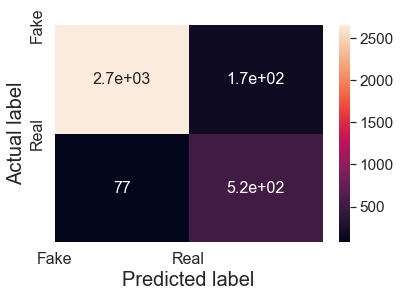

True positives =  2655
False positives =  170
False negatives =  77
True negatives =  524


Accuracy:  92.79042615294804
Precision:  0.9398230088495575
Recall:  0.9718155197657394


In [22]:
#confusion matrix for CNN 
print(confusion_matrix(true,pred)) 
print_confusion_matrix(true,pred) 

In [27]:

import numpy as np
 
from sklearn .metrics import roc_auc_score
 

auc = np.round(roc_auc_score(true, pred), 3)
 
print("Auc for our test data is {}". format(auc))

Auc for our test data is 0.883


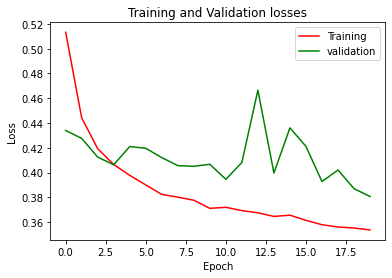

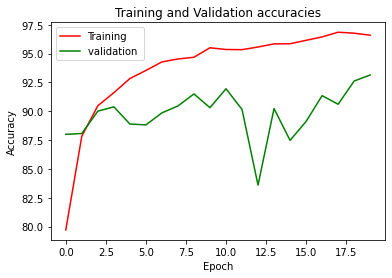

In [17]:
#plot of loss and accuracy for CNN
plot_loss(train_loss_avg,val_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,val_accuracy,len(train_accuracy))

[[828  33]
 [ 59 421]]


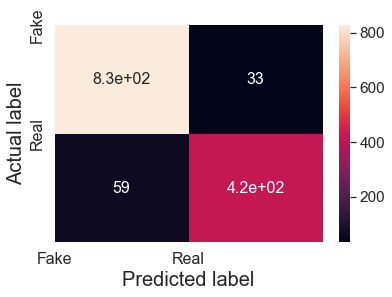

True positives =  828
False positives =  33
False negatives =  59
True negatives =  421


Accuracy:  93.13944817300522
Precision:  0.9616724738675958
Recall:  0.9334836527621195


In [18]:
#confusion matrix for CNN 
print(confusion_matrix(true,pred)) 
print_confusion_matrix(true,pred) 